# Prediction of the KS system: a model using Convolutional Neural Network

In this notebook, I will use the CNN to predict many step of the KS system

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [10]:
cd ../content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [11]:
import numpy as np
import torch as th
import time
from scipy import stats
#from KS import KS
import matplotlib.pyplot as plt
from sklearn import preprocessing

## Some functions

In [12]:
def drawKS(U_sim, x_axis, t_axis ,startT=0,endT=0, width = 10, divwidth = 4): 
    """
    This function will plot the evolution of the KS system (U_sim) over time (t_axis)
    
    """
    fig = plt.figure(figsize=(width, width/divwidth))
    ax = fig.gca()
    ola = ax.contourf((t_axis[startT:endT])/20.83, x_axis, U_sim[startT:endT,:].T, 15)
    cbar = plt.colorbar(ola)
    plt.xlabel('Lyapunov Times')
    plt.ylabel('X')
    plt.show()

In [13]:
def prediction(model,start_position,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th):
    """
    This function will simulate the model for a given start_position of 
    state_history_norm_th from start_position to start_position+N_step_pred
    and compares this simulation with the true value given by state_history_norm_th
    
    input:
    - model: the model that will be used to make the prediction
    - start_position: the position in the vector state_history_norm_th that will start the simulation
    - N_step_pred: number of the steps to simulate
    - state_history_norm_th: the true simulation given by KS.py. it will be used as the start point
      to initiate our model simulation and to verify the quality of this simulation
    
    
    output:
    - print: the true spatiotemporal evolution of KS system
             our simulation by the model
             the difference between them per step of the simulation
    
    state_history: all the spatialtemporal evolution of the system. shape: [number of iteractions,samples_points]
    time_counter: array of the time corresponding to each interaction
    position_x: array of samples_points points that goes from 0 to length
    """

    y_true=state_history_norm_th[start_position:start_position+(N_step_simu*steps_to_predict),:].squeeze()
    sample_points=state_history_norm_th.size(1)
    current_state = th.zeros((1, sample_points, size_conv_time))
    current_state[0,:,:] = state_history_norm_th[start_position-(size_conv_time):start_position,:].T
    current_state=current_state.double().cuda()
    prediction_model = th.zeros((N_step_simu, steps_to_predict,sample_points))

    for i in range(N_step_simu):
        y=model(current_state)
        yy=y[0].reshape(sample_points,steps_to_predict)
        yy=yy.T
        prediction_model[i,:,:]=yy
        y=y.reshape(1,sample_points,steps_to_predict)
        past=current_state[:,:,steps_to_predict:]
        current_state=th.zeros(1,sample_points,size_conv_time).double().cuda()
        current_state[:,:,0:(size_conv_time-steps_to_predict)]=past
        current_state[:,:,(size_conv_time-steps_to_predict):]=y


    prediction_model_np = prediction_model.detach().numpy()
    prediction_model_np= prediction_model_np.reshape(N_step_simu*steps_to_predict,sample_points)
    y_true_np = y_true.cpu().numpy()
    dif=np.mean(np.absolute(prediction_model_np-y_true_np),axis=1)

    print('The true solution:')
    drawKS(y_true_np, position_x, time_counter,startT=1,endT=N_step_simu*steps_to_predict, width = 10, divwidth = 4) 
    print('The model solution:')
    drawKS(prediction_model_np, position_x,time_counter,startT=1,endT=N_step_simu*steps_to_predict, width = 10, divwidth = 4)
    print('The difference between them:')
    drawKS(np.absolute(y_true_np-prediction_model_np), position_x,time_counter,startT=1,endT=N_step_simu*steps_to_predict, width = 10, divwidth = 4)

    plt.figure(figsize = (8, 3))
    plt.plot(np.arange(N_step_simu*steps_to_predict)*0.25/20.83, np.absolute(dif))
    plt.title('Difference between prediction and true value')
    plt.ylabel('MAE')
    plt.xlabel('Lyapunov Times')

    return prediction_model_np,y_true_np

In [14]:
def prediction2(model,start_position,N_step_pred,state_history_norm_th):
    """
    This function will simulate the model for a given start_position of 
    state_history_norm_th from start_position to start_position+N_step_pred
    and compares this simulation with the true value given by state_history_norm_th
    
    input:
    - model: the model that will be used to make the prediction
    - start_position: the position in the vector state_history_norm_th that will start the simulation
    - N_step_pred: number of the steps to simulate
    - state_history_norm_th: the true simulation given by KS.py. it will be used as the start point
      to initiate our model simulation and to verify the quality of this simulation
    
    
    output:
    - print: the true spatiotemporal evolution of KS system
             our simulation by the model
             the difference between them per step of the simulation
    
    state_history: all the spatialtemporal evolution of the system. shape: [number of iteractions,samples_points]
    time_counter: array of the time corresponding to each interaction
    position_x: array of samples_points points that goes from 0 to length
    """
    
    y_true=state_history_norm_th[:,start_position:start_position+N_step_pred,:].squeeze()
    sample_points=state_history_norm_th.size(2)
    current_state = state_history_norm_th[:,start_position-100:start_position,:]
    prediction_model = th.zeros((N_step_pred, sample_points))

    for i in range(N_step_pred):
        y=model(current_state)
        past=current_state[:,1:100,:]
        current_state=th.zeros(1,100,64).double().cuda()
        current_state[:,0:99,:]=past
        current_state[:,99,:]=y
        prediction_model[i,:]=y.squeeze()


    prediction_model_np = prediction_model.detach().numpy()
    y_true_np = y_true.cpu().numpy()
    dif=np.mean(np.absolute(prediction_model_np-y_true_np),axis=1)


    print('The true solution:')
    drawKS(y_true_np, position_x, time_counter[start_position:start_position+N_step_pred] ,startT=1,endT=N_step_pred, width = 10, divwidth = 4) 
    print('The model solution:')
    drawKS(prediction_model_np, position_x,time_counter[start_position:start_position+N_step_pred] ,startT=1,endT=N_step_pred, width = 10, divwidth = 4)

    plt.plot(np.absolute(dif))
    plt.title('Difference between prediction and true value')
    plt.ylabel('Delta')
    plt.xlabel('Time step')

## Loading and normalizing the data
First, let's set the parameters of the simulation. Pay attention to set the correct parameters to the data set loaded.

In [15]:
final_time = 2500 # the total time of the simulation
dt = 0.25 # the time step 
length = 22 # the "physical" length of the domaine. pay attention cuz this value will determine if the system is regular or chaotic
sample_points = 64 # the number of sample points on this length. It will be the size of the input in our system

In [16]:
#to load data
from numpy import load

number_of_sets = 50

state_history = np.loadtxt('state_history_5_trainingtotal.dat')
time_counter = np.linspace(0,2000*number_of_sets,8001*number_of_sets)
position_x = np.loadtxt('position_5_0.dat')

Let's normalize the data to be between [-0.975,0.975]. It will allow us to use other activation fonction (like Tanh):

In [17]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-0.975,0.975))
state_history_norm = min_max_scaler.fit_transform(state_history)
del state_history

## Separating the data into training and test sets

In [19]:
#state_history_norm=state_history_norm[:8001*number_of_sets,:]
#até 100.000 vai, com 200.000 o colabs nao aguenta
state_history_norm.shape

(400050, 64)

In [11]:
to_ignore = 1

size_conv_time=25
steps_to_predict=10

X = state_history_norm[:-size_conv_time,:] #our input: all the data excluding the last size_conv_time data
Y = state_history_norm[size_conv_time:,:] #our output: all the data minus the first size_conv_time one

NN = state_history_norm.shape[0]-2*size_conv_time-4*number_of_sets*to_ignore
Nt = int(NN*0.9) # number of train
Nv = int(NN*0.1) # number of validation

np.random.seed(0)

seq1 = np.arange(8001)
seq1 = seq1[to_ignore:8001-to_ignore]
tam = seq1.shape[0]
indices = np.zeros((tam*(number_of_sets-1)+tam-size_conv_time*2))
for i in range(number_of_sets):
  if i==number_of_sets-1:
    indices[tam*i:] = (seq1[:-size_conv_time*2]+8001*i)
  else:
    indices[tam*i:tam*(i+1)] = (seq1+8001*i)

indices = indices.astype(np.integer)


#np.random.shuffle(indices)
train_ind=indices[0:Nt]
valid_ind=indices[-Nv:]


X_train = np.zeros((Nt, sample_points, size_conv_time))
aux=0
for ind in train_ind:
    X_train[aux,:,:]=X[ind:ind+size_conv_time].T
    aux=aux+1

Y_train = np.zeros((Nt, sample_points, steps_to_predict))
aux=0
for ind in train_ind:
    Y_train[aux,:,:]=Y[ind:ind+steps_to_predict].T
    aux=aux+1

Y_train = Y_train.reshape(Nt,sample_points*steps_to_predict)

#X_valid = np.zeros((Nv, sample_points, size_conv_time))
aux=0
#for ind in valid_ind:
#    X_valid[aux,:,:]=X[ind:ind+size_conv_time].T
#    aux=aux+1

#Y_valid = np.zeros((Nv, sample_points, steps_to_predict))
aux=0
#for ind in valid_ind:
#    Y_valid[aux,:,:]=Y[ind:ind+steps_to_predict].T
#    aux=aux+1

#Y_valid = Y_valid.reshape(Nv,sample_points*steps_to_predict)

#converting to tensor
X_train_th = th.from_numpy(X_train).cuda()
Y_train_th = th.from_numpy(Y_train).cuda()
#X_valid_th = th.from_numpy(X_valid).cuda()
#Y_valid_th = th.from_numpy(Y_valid).cuda()

## Training

In [10]:
def train(model,X_train,X_valid,Y_train,Y_valid,epochs=1000,batch_size=64):
    Nt=len(X_train)
    Nv=len(X_valid)
    ### Mini-batching and shuffle
    idx = np.arange(Nt)
    nbatch = int(Nt/batch_size)
    train_losses,valid_losses=[],[]
    start_time=time.time()
    print("Epoch\tTrain Loss\tValid Loss")
    
    #Just to see the prediction of our random parameters
    model.eval()
    with th.no_grad():
        running_loss=0
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            x = X_train[ids]
            ttf_calc=model(x).squeeze()
            ttf = Y_train[ids]
            loss=loss_fn(ttf_calc,ttf)
            running_loss+=loss.item()
        train_losses.append(running_loss/nbatch)
        running_loss=0
        ttf_calc=model(X_valid).squeeze()
        ttf = Y_valid
        loss=loss_fn(ttf_calc,ttf)
        running_loss+=loss.item()
        valid_losses.append(running_loss)
        #it will print the result in epoch=0 during the training
    
    #starting the training here:
    for e in range(epochs):
        model.train()
        print("{}\t".format(e),"{:.5f}..\t".format(train_losses[-1]),"{:.5f}..".format(valid_losses[-1]))  
        np.random.shuffle(idx)
        running_loss=0
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            x = X_train[ids]
            optimizer.zero_grad()
            ttf_calc=model(x).squeeze()
            ttf = Y_train[ids]
            loss=loss_fn(ttf_calc,ttf)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            
        # training is over for one epoch
        #now evaluate the model with the valid set:
        model.eval()
        accuracy=0
        train_losses.append(running_loss/nbatch)
        running_loss=0
        with th.no_grad():
            x = X_valid
            ttf_calc=model(x).squeeze()
            ttf = Y_valid
            loss=loss_fn(ttf_calc,ttf)
            running_loss+=loss.item()
            valid_losses.append(running_loss)
    print("{}\t".format(e+1),"{:.5f}..\t".format(train_losses[-1]),"{:.5f}..".format(valid_losses[-1]))     
    print("---------- Best : {:.3f}".format(min(valid_losses)), " at epoch " 
          , np.fromiter(valid_losses, dtype=np.float).argmin(), " / ",epochs )
    print('Execution time={:.2f}s'.format(time.time()-start_time))
    #plot some graphs
    #plt.figure(figsize = (9, 1.5))
    #ax= plt.subplot(1, 2, 1)
    #plt.plot(train_losses)
    #ax.set_ylim(bottom=0)
    #ax= plt.subplot(1, 2, 2)
    #plt.plot(valid_losses)
    #ax.set_ylim(bottom=0)
    return train_losses, valid_losses

In [18]:
def train2(model,X_train,Y_train,epochs=1000,batch_size=64):
    
    #WITHOUT THE TEST SET
    
    Nt=len(X_train)
    ### Mini-batching and shuffle
    idx = np.arange(Nt)
    nbatch = int(Nt/batch_size)
    train_losses,valid_losses=[],[]
    start_time=time.time()
    print("Epoch\tTrain Loss")
    
    #Just to see the prediction of our random parameters
    model.eval()
    with th.no_grad():
        running_loss=0
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            x = X_train[ids]
            ttf_calc=model(x).squeeze()
            ttf = Y_train[ids]
            loss=loss_fn(ttf_calc,ttf)
            running_loss+=loss.item()
        train_losses.append(running_loss/nbatch)
        running_loss=0
        #ttf_calc=model(X_valid).squeeze()
        #ttf = Y_valid
        #loss=loss_fn(ttf_calc,ttf)
        #running_loss+=loss.item()
        #valid_losses.append(running_loss)
        #it will print the result in epoch=0 during the training
    
    #starting the training here:
    for e in range(epochs):
        model.train()
        print("{}\t".format(e),"{:.7f}..\t".format(train_losses[-1]))  
        np.random.shuffle(idx)
        running_loss=0
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            x = X_train[ids]
            optimizer.zero_grad()
            ttf_calc=model(x).squeeze()
            ttf = Y_train[ids]
            loss=loss_fn(ttf_calc,ttf)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            
        # training is over for one epoch
        #now evaluate the model with the valid set:
        model.eval()
        accuracy=0
        train_losses.append(running_loss/nbatch)
    print("{}\t".format(e+1),"{:.7f}..\t".format(train_losses[-1]))     
    #print("---------- Best : {:.3f}".format(min(valid_losses)), " at epoch " 
    #      , np.fromiter(valid_losses, dtype=np.float).argmin(), " / ",epochs )
    #print('Execution time={:.2f}s'.format(time.time()-start_time))
    #plot some graphs
    #plt.figure(figsize = (9, 1.5))
    #ax= plt.subplot(1, 2, 1)
    #plt.plot(train_losses)
    #ax.set_ylim(bottom=0)
    #ax= plt.subplot(1, 2, 2)
    #plt.plot(valid_losses)
    #ax.set_ylim(bottom=0)

## Model 1

In [ ]:
Lin = 100
in_ch_conv_1 = 64
out_ch_conv_1 = 128
k_conv_1 = 10
st_conv_1 = 2
pad_conv_1 = 4
L_2 = (Lin+2*pad_conv_1-(k_conv_1-1)-1)/st_conv_1+1

k_pool_1= 2
st_pool_1= 2
L_3 = (L_2 - k_pool_1)/st_pool_1 + 1

in_ch_conv_2 = 128
out_ch_conv_2 = 64
k_conv_2 = 5
st_conv_2 = 2
pad_conv_2 = 1
L_4 = (L_3+2*pad_conv_2-(k_conv_2-1)-1)/st_conv_2+1

k_pool_2= 12
st_pool_2= 1
L_5 = (L_4 - k_pool_2)/st_pool_2 + 1

in_lin = sample_points
hidden_1 = sample_points*5
out_lin = sample_points*10


model = th.nn.Sequential(
    th.nn.Conv1d(in_ch_conv_1,out_ch_conv_1,k_conv_1,st_conv_1,pad_conv_1),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_1,st_pool_1),
    th.nn.Conv1d(in_ch_conv_2,out_ch_conv_2,k_conv_2,st_conv_2,pad_conv_2),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_2,st_pool_2),
    th.nn.Flatten(),
    th.nn.Linear(in_lin,hidden_1),
    th.nn.LeakyReLU(),
    th.nn.Linear(hidden_1,out_lin),
    th.nn.Tanh(),
)
model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()

In [8]:
epochs_counter=500
batch_size=64
#train_losses, valid_losses = train(model,X_train_th,X_valid_th,Y_train_th,Y_valid_th,epochs=epochs_counter,batch_size=batch_size)

In [ ]:
#TO SAVE THE MODEL

tosave_data = {'model': model,
               'epoch': epoch,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,
               'training loss': train_losses,
               'valid loss': valid_losses,}
# Write a pickle file using pytorch 
th.save(tosave_data, "modelcv3_model1")

In [ ]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()
#state_history_norm_th = state_history_norm_th.unsqueeze(0)
start_position=200
N_step_simu=4
print('Start_position=', start_position)
pp,yy = prediction(model,start_position,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)


## Model 2

In [19]:
Lin = 150
in_ch_conv_1 = 64
out_ch_conv_1 = 128
k_conv_1 = 4
st_conv_1 = 2
pad_conv_1 = 4
L_2 = (Lin+2*pad_conv_1-(k_conv_1-1)-1)/st_conv_1+1

k_pool_1= 2
st_pool_1= 2
L_3 = (L_2 - k_pool_1)/st_pool_1 + 1

in_ch_conv_2 = 128
out_ch_conv_2 = 64
k_conv_2 = 5
st_conv_2 = 2
pad_conv_2 = 1
L_4 = (L_3+2*pad_conv_2-(k_conv_2-1)-1)/st_conv_2+1

k_pool_2= 5
st_pool_2= 2
L_5 = (L_4 - k_pool_2)/st_pool_2 + 1

in_lin = int(sample_points*L_5)
hidden_1 = sample_points*25
out_lin = sample_points*50

model = th.nn.Sequential(
    th.nn.Conv1d(in_ch_conv_1,out_ch_conv_1,k_conv_1,st_conv_1,pad_conv_1),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_1,st_pool_1),
    th.nn.Conv1d(in_ch_conv_2,out_ch_conv_2,k_conv_2,st_conv_2,pad_conv_2),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_2,st_pool_2),
    th.nn.Flatten(),
    th.nn.Linear(in_lin,hidden_1),
    th.nn.LeakyReLU(),
    th.nn.Linear(hidden_1,out_lin),
    th.nn.Tanh(),
)
model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()

In [21]:
model

Sequential(
  (0): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(4,))
  (1): LeakyReLU(negative_slope=0.01)
  (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv1d(128, 64, kernel_size=(5,), stride=(2,), padding=(1,))
  (4): LeakyReLU(negative_slope=0.01)
  (5): MaxPool1d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=512, out_features=1600, bias=True)
  (8): LeakyReLU(negative_slope=0.01)
  (9): Linear(in_features=1600, out_features=3200, bias=True)
  (10): Tanh()
)

In [20]:
#loop to training with different parts of the dataset - I cannot training with all dataset at one time
from numpy import load

#to load data
number_of_sets = 10
state_history = np.loadtxt('state_history_5_trainingtotal.dat')
time_counter = np.linspace(0,2000*number_of_sets,8001*number_of_sets)
position_x = np.loadtxt('position_5_0.dat')
#to normalize the data
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-0.975,0.975))
state_history_norm_total = min_max_scaler.fit_transform(state_history)

epochs_counter=10
batch_size=64

to_ignore = 1

size_conv_time=150
steps_to_predict=50



for j in range(10):
  #to do the process 10x.
  for i in range(5):
    #to select the correct part of the data
    state_history_norm=state_history_norm_total[(8001*i*number_of_sets):(8001*(i+1)*number_of_sets),:]

    to_ignore = 1
    size_conv_time=150
    steps_to_predict=50

    X = state_history_norm[:-size_conv_time,:] #our input: all the data excluding the last size_conv_time data
    Y = state_history_norm[size_conv_time:,:] #our output: all the data minus the first size_conv_time one

    NN = state_history_norm.shape[0]-2*size_conv_time-4*number_of_sets*to_ignore
    Nt = int(NN*0.9) # number of train
    Nv = int(NN*0.1) # number of validation

    np.random.seed(0)

    seq1 = np.arange(8001)
    seq1 = seq1[to_ignore:8001-to_ignore]
    tam = seq1.shape[0]
    indices = np.zeros((tam*(number_of_sets-1)+tam-size_conv_time*2))
    for i in range(number_of_sets):
      if i==number_of_sets-1:
        indices[tam*i:] = (seq1[:-size_conv_time*2]+8001*i)
      else:
        indices[tam*i:tam*(i+1)] = (seq1+8001*i)

    indices = indices.astype(np.integer)


    np.random.shuffle(indices)
    train_ind=indices[0:Nt]
    valid_ind=indices[-Nv:]


    X_train = np.zeros((Nt, sample_points, size_conv_time))
    aux=0
    for ind in train_ind:
        X_train[aux,:,:]=X[ind:ind+size_conv_time].T
        aux=aux+1

    Y_train = np.zeros((Nt, sample_points, steps_to_predict))
    aux=0
    for ind in train_ind:
        Y_train[aux,:,:]=Y[ind:ind+steps_to_predict].T
        aux=aux+1

    Y_train = Y_train.reshape(Nt,sample_points*steps_to_predict)

    X_valid = np.zeros((Nv, sample_points, size_conv_time))
    aux=0
    for ind in valid_ind:
        X_valid[aux,:,:]=X[ind:ind+size_conv_time].T
        aux=aux+1

    Y_valid = np.zeros((Nv, sample_points, steps_to_predict))
    aux=0
    for ind in valid_ind:
        Y_valid[aux,:,:]=Y[ind:ind+steps_to_predict].T
        aux=aux+1

    Y_valid = Y_valid.reshape(Nv,sample_points*steps_to_predict)

    #converting to tensor
    X_train_th = th.from_numpy(X_train).cuda()
    Y_train_th = th.from_numpy(Y_train).cuda()
    X_valid_th = th.from_numpy(X_valid).cuda()
    Y_valid_th = th.from_numpy(Y_valid).cuda()

    del Y_train
    del X_train
    del Y_valid
    del X_valid
    del X
    del Y
    del indices
    del NN 
    del Nt
    del train_ind

    train_losses, valid_losses = train(model,X_train_th,X_valid_th,Y_train_th,Y_valid_th,epochs=epochs_counter,batch_size=batch_size)
    #train2(model,X_train_th,Y_train_th,epochs=epochs_counter,batch_size=64)

    del X_train_th
    del Y_train_th
    del X_valid_th
    del Y_valid_th
    del state_history_norm

Epoch	Train Loss	Valid Loss
0	 0.14115..	 0.14081..
1	 0.11135..	 0.09726..
2	 0.08925..	 0.08209..
3	 0.07696..	 0.07165..
4	 0.06764..	 0.06336..
5	 0.06041..	 0.05725..
6	 0.05514..	 0.05263..
7	 0.05106..	 0.04902..
8	 0.04769..	 0.04591..
9	 0.04475..	 0.04326..
10	 0.04216..	 0.04080..
---------- Best : 0.041  at epoch  10  /  10
Execution time=283.22s
Epoch	Train Loss	Valid Loss
0	 0.04950..	 0.04906..
1	 0.04616..	 0.04381..
2	 0.04265..	 0.04123..
3	 0.04002..	 0.03874..
4	 0.03775..	 0.03661..
5	 0.03569..	 0.03463..
6	 0.03382..	 0.03291..
7	 0.03212..	 0.03131..
8	 0.03057..	 0.02989..
9	 0.02916..	 0.02855..
10	 0.02787..	 0.02731..
---------- Best : 0.027  at epoch  10  /  10
Execution time=283.26s
Epoch	Train Loss	Valid Loss
0	 0.03535..	 0.03514..
1	 0.03246..	 0.03063..
2	 0.02977..	 0.02877..
3	 0.02798..	 0.02720..
4	 0.02651..	 0.02589..
5	 0.02521..	 0.02470..
6	 0.02408..	 0.02366..
7	 0.02305..	 0.02266..
8	 0.02211..	 0.02185..
9	 0.02126..	 0.02104..
10	 0.0204

In [35]:
#TO SAVE THE MODEL

tosave_data = {'model': model,
               'epoch': epochs_counter,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,
               'training loss': train_losses,
               'valid loss': valid_losses,}
# Write a pickle file using pytorch
th.save(tosave_data, "modelcv3_model2_500epochs")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-35-12573a936241>", line 12, in <module>
    th.save(tosave_data, "modelcv3_model2_500epochs")
  File "/usr/local/lib/python3.6/dist-packages/torch/serialization.py", line 361, in save
    with _open_file_like(f, 'wb') as opened_file:
  File "/usr/local/lib/python3.6/dist-packages/torch/serialization.py", line 229, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/usr/local/lib/python3.6/dist-packages/torch/serialization.py", line 210, in __init__
    super(_open_file, self).__init__(open(name, mode))
OSError: [Errno 107] Transport endpoint is not connected: 'modelcv3_model2_500epochs'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/inte

OSError: ignored

Start_position= 11000
The true solution:


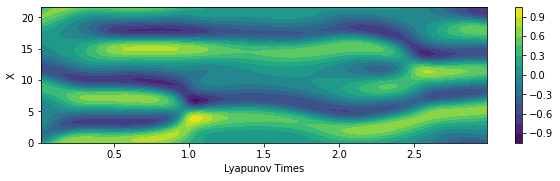

The model solution:


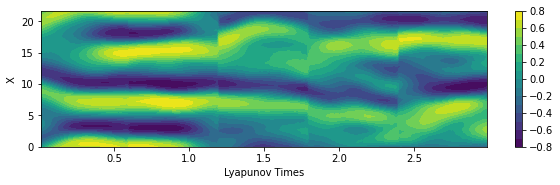

The difference between them:


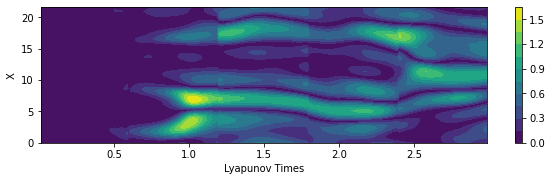

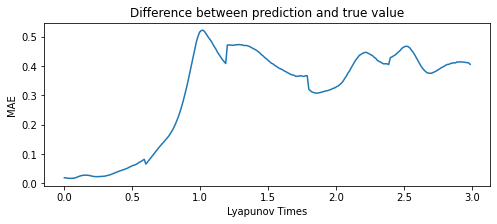

In [34]:
state_history_norm_th = th.from_numpy(state_history_norm_total).cuda()
#state_history_norm_th = state_history_norm_th.unsqueeze(0)
start_position=11000
N_step_simu=5
print('Start_position=', start_position)
pp,yy = prediction(model,start_position,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)

Start_position= 11000
The true solution:


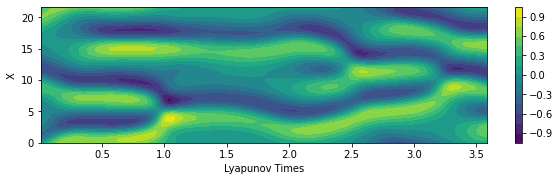

The model solution:


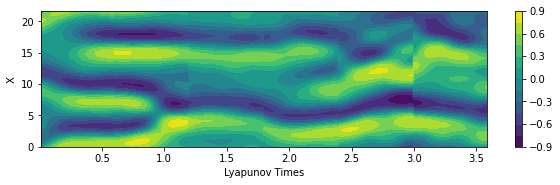

The difference between them:


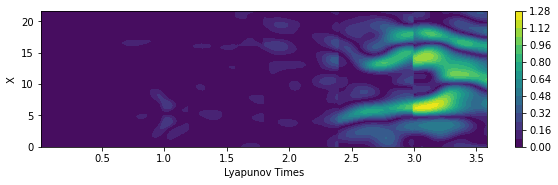

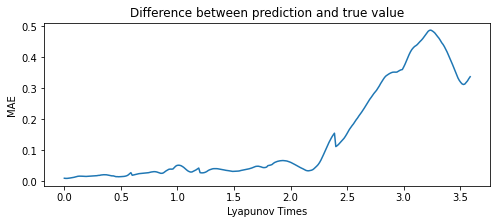

In [ ]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()
#state_history_norm_th = state_history_norm_th.unsqueeze(0)
start_position=11000
N_step_simu=6
print('Start_position=', start_position)
pp,yy = prediction(model,start_position,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)

### Training with different epochs

In [ ]:
for i in range(50):
    epochs_counter=5
    batch_size=64
    train_losses, valid_losses = train(model,X_train_th,X_valid_th,Y_train_th,Y_valid_th,epochs=epochs_counter,batch_size=batch_size)
    tosave_data = {'model': model,
               'epoch': epochs_counter,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,
               'training loss': train_losses,
               'valid loss': valid_losses,}
    th.save(tosave_data, str(i))

### Training with different steps_to_predict

In [ ]:
#conv: 2
#linear: 2

n_trainings=10
steps_to_pred = np.linspace(2,20,n_trainings)
size_conv_time = 25

for j in range(n_trainings):

  Lin = size_conv_time
  in_ch_conv_1 = 64
  out_ch_conv_1 = 128
  k_conv_1 = 5
  st_conv_1 = 2
  pad_conv_1 = 2
  L_2 = (Lin+2*pad_conv_1-(k_conv_1-1)-1)/st_conv_1+1

  k_pool_1= 3
  st_pool_1= 1
  L_3 = (L_2 - k_pool_1)/st_pool_1 + 1

  in_ch_conv_2 = 128
  out_ch_conv_2 = 64
  k_conv_2 = 4
  st_conv_2 = 1
  pad_conv_2 = 1
  L_4 = (L_3+2*pad_conv_2-(k_conv_2-1)-1)/st_conv_2+1

  k_pool_2= 2
  st_pool_2= 1
  L_5 = (L_4 - k_pool_2)/st_pool_2 + 1

  print(L_2)
  print(L_3)
  print(L_4)
  print(L_5)

  in_lin = int(sample_points*L_5)
  out_lin = int(sample_points*steps_to_pred[j])
  hidden_lin = sample_points*5

  model2_2 = th.nn.Sequential(
      th.nn.Conv1d(in_ch_conv_1,out_ch_conv_1,k_conv_1,st_conv_1,pad_conv_1),
      th.nn.LeakyReLU(),
      th.nn.MaxPool1d(k_pool_1,st_pool_1),
      th.nn.Conv1d(in_ch_conv_2,out_ch_conv_2,k_conv_2,st_conv_2,pad_conv_2),
      th.nn.LeakyReLU(),
      th.nn.MaxPool1d(k_pool_2,st_pool_2),
      th.nn.Flatten(),
      th.nn.Linear(in_lin,hidden_lin),
      th.nn.Tanh(),
      th.nn.Linear(hidden_lin,out_lin),
      th.nn.Tanh(),
  )
  model2_2.double()
  model2_2.cuda()
  optimizer=th.optim.Adam(model2_2.parameters(),lr=1e-5)
  loss_fn=th.nn.MSELoss()

  steps_to_predict=int(steps_to_pred[j])
  to_ignore = 1

  X = state_history_norm[:-size_conv_time,:] #our input: all the data excluding the last size_conv_time data
  Y = state_history_norm[size_conv_time:,:] #our output: all the data minus the first size_conv_time one

  NN = state_history_norm.shape[0]-2*size_conv_time-4*number_of_sets*to_ignore
  Nt = int(NN*0.9) # number of train
  Nv = int(NN*0.1) # number of validation

  np.random.seed(0)

  seq1 = np.arange(8001)
  seq1 = seq1[to_ignore:8001-to_ignore]
  tam = seq1.shape[0]
  indices = np.zeros((tam*(number_of_sets-1)+tam-size_conv_time*2))
  for i in range(number_of_sets):
    if i==number_of_sets-1:
      indices[tam*i:] = (seq1[:-size_conv_time*2]+8001*i)
    else:
      indices[tam*i:tam*(i+1)] = (seq1+8001*i)

  indices = indices.astype(np.integer)


  #np.random.shuffle(indices)
  train_ind=indices[0:Nt]
  valid_ind=indices[-Nv:]


  X_train = np.zeros((Nt, sample_points, size_conv_time))
  aux=0
  for ind in train_ind:
      X_train[aux,:,:]=X[ind:ind+size_conv_time].T
      aux=aux+1

  Y_train = np.zeros((Nt, sample_points, steps_to_predict))
  aux=0
  for ind in train_ind:
      Y_train[aux,:,:]=Y[ind:ind+steps_to_predict].T
      aux=aux+1

  Y_train = Y_train.reshape(Nt,sample_points*steps_to_predict)

  #X_valid = np.zeros((Nv, sample_points, size_conv_time))
  aux=0
  #for ind in valid_ind:
  #    X_valid[aux,:,:]=X[ind:ind+size_conv_time].T
  #    aux=aux+1

  #Y_valid = np.zeros((Nv, sample_points, steps_to_predict))
  aux=0
  #for ind in valid_ind:
  #    Y_valid[aux,:,:]=Y[ind:ind+steps_to_predict].T
  #    aux=aux+1

  #Y_valid = Y_valid.reshape(Nv,sample_points*steps_to_predict)

  #converting to tensor
  X_train_th = th.from_numpy(X_train).cuda()
  Y_train_th = th.from_numpy(Y_train).cuda()
  #X_valid_th = th.from_numpy(X_valid).cuda()
  #Y_valid_th = th.from_numpy(Y_valid).cuda()

  epochs_counter=100
  batch_size=64
  train2(model2_2,X_train_th,Y_train_th,epochs=epochs_counter,batch_size=batch_size)

  #TO SAVE THE MODEL
  tosave_data = {'model': model2_2,
                'epoch': epochs_counter,
                'batch_size': batch_size,
                'model_state_dict': model2_2.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_fn,}
  # Write a pickle file using pytorch
  th.save(tosave_data, "modelcv_model2_2_500epochs_stepspred"+str(j))

  del Y_train
  del X_train
  del X
  del Y
  del indices
  del NN 
  del Nt
  del train_ind
  del X_train_th
  del Y_train_th

13.0
11.0
10.0
9.0
Epoch	Train Loss
0	 0.1417472..	
1	 0.0200909..	
2	 0.0016735..	
3	 0.0008505..	
4	 0.0006402..	
5	 0.0005465..	
6	 0.0004907..	
7	 0.0004517..	
8	 0.0004222..	
9	 0.0003986..	
10	 0.0003792..	
11	 0.0003625..	
12	 0.0003482..	
13	 0.0003355..	
14	 0.0003242..	
15	 0.0003141..	
16	 0.0003046..	
17	 0.0002963..	
18	 0.0002885..	
19	 0.0002812..	
20	 0.0002743..	
21	 0.0002680..	
22	 0.0002621..	
23	 0.0002566..	
24	 0.0002513..	
25	 0.0002464..	
26	 0.0002417..	
27	 0.0002372..	
28	 0.0002331..	
29	 0.0002291..	
30	 0.0002251..	
31	 0.0002216..	
32	 0.0002180..	
33	 0.0002146..	
34	 0.0002114..	
35	 0.0002083..	
36	 0.0002054..	
37	 0.0002025..	
38	 0.0001998..	
39	 0.0001971..	
40	 0.0001945..	
41	 0.0001922..	
42	 0.0001896..	
43	 0.0001873..	
44	 0.0001851..	
45	 0.0001831..	
46	 0.0001809..	
47	 0.0001791..	
48	 0.0001771..	
49	 0.0001753..	
50	 0.0001734..	
51	 0.0001715..	
52	 0.0001700..	
53	 0.0001684..	
54	 0.0001666..	
55	 0.0001650..	
56	 0.0001635..	
57	 0

### Training with different size_conv_time

In [ ]:
#conv: 2
#linear: 2

n_trainings=10
conv_time = np.linspace(2,20,n_trainings)
steps_to_predict=10

for j in range(n_trainings):

  Lin = int(conv_time[j])
  in_ch_conv_1 = 64
  out_ch_conv_1 = 128
  k_conv_1 = 2
  st_conv_1 = 1
  pad_conv_1 = 2
  L_2 = (Lin+2*pad_conv_1-(k_conv_1-1)-1)/st_conv_1+1

  k_pool_1= 2
  st_pool_1= 1
  L_3 = (L_2 - k_pool_1)/st_pool_1 + 1

  in_ch_conv_2 = 128
  out_ch_conv_2 = 64
  k_conv_2 = 2
  st_conv_2 = 1
  pad_conv_2 = 1
  L_4 = (L_3+2*pad_conv_2-(k_conv_2-1)-1)/st_conv_2+1

  k_pool_2= 2
  st_pool_2= 1
  L_5 = (L_4 - k_pool_2)/st_pool_2 + 1

  print(L_2)
  print(L_3)
  print(L_4)
  print(L_5)

  in_lin = int(sample_points*L_5)
  out_lin = int(sample_points*steps_to_predict)
  hidden_lin = sample_points*7

  model2_2 = th.nn.Sequential(
      th.nn.Conv1d(in_ch_conv_1,out_ch_conv_1,k_conv_1,st_conv_1,pad_conv_1),
      th.nn.LeakyReLU(),
      th.nn.MaxPool1d(k_pool_1,st_pool_1),
      th.nn.Conv1d(in_ch_conv_2,out_ch_conv_2,k_conv_2,st_conv_2,pad_conv_2),
      th.nn.LeakyReLU(),
      th.nn.MaxPool1d(k_pool_2,st_pool_2),
      th.nn.Flatten(),
      th.nn.Linear(in_lin,hidden_lin),
      th.nn.Tanh(),
      th.nn.Linear(hidden_lin,out_lin),
      th.nn.Tanh(),
  )
  model2_2.double()
  model2_2.cuda()
  optimizer=th.optim.Adam(model2_2.parameters(),lr=1e-5)
  loss_fn=th.nn.MSELoss()


  size_conv_time=int(conv_time[j])
  to_ignore = 1
  steps_to_predict=10

  X = state_history_norm[:-size_conv_time,:] #our input: all the data excluding the last size_conv_time data
  Y = state_history_norm[size_conv_time:,:] #our output: all the data minus the first size_conv_time one

  NN = state_history_norm.shape[0]-2*size_conv_time-4*number_of_sets*to_ignore
  Nt = int(NN*0.9) # number of train
  Nv = int(NN*0.1) # number of validation

  np.random.seed(0)

  seq1 = np.arange(8001)
  seq1 = seq1[to_ignore:8001-to_ignore]
  tam = seq1.shape[0]
  indices = np.zeros((tam*(number_of_sets-1)+tam-size_conv_time*2))
  for i in range(number_of_sets):
    if i==number_of_sets-1:
      indices[tam*i:] = (seq1[:-size_conv_time*2]+8001*i)
    else:
      indices[tam*i:tam*(i+1)] = (seq1+8001*i)

  indices = indices.astype(np.integer)


  #np.random.shuffle(indices)
  train_ind=indices[0:Nt]
  valid_ind=indices[-Nv:]


  X_train = np.zeros((Nt, sample_points, size_conv_time))
  aux=0
  for ind in train_ind:
      X_train[aux,:,:]=X[ind:ind+size_conv_time].T
      aux=aux+1

  Y_train = np.zeros((Nt, sample_points, steps_to_predict))
  aux=0
  for ind in train_ind:
      Y_train[aux,:,:]=Y[ind:ind+steps_to_predict].T
      aux=aux+1

  Y_train = Y_train.reshape(Nt,sample_points*steps_to_predict)

  #X_valid = np.zeros((Nv, sample_points, size_conv_time))
  aux=0
  #for ind in valid_ind:
  #    X_valid[aux,:,:]=X[ind:ind+size_conv_time].T
  #    aux=aux+1

  #Y_valid = np.zeros((Nv, sample_points, steps_to_predict))
  aux=0
  #for ind in valid_ind:
  #    Y_valid[aux,:,:]=Y[ind:ind+steps_to_predict].T
  #    aux=aux+1

  #Y_valid = Y_valid.reshape(Nv,sample_points*steps_to_predict)

  #converting to tensor
  X_train_th = th.from_numpy(X_train).cuda()
  Y_train_th = th.from_numpy(Y_train).cuda()
  #X_valid_th = th.from_numpy(X_valid).cuda()
  #Y_valid_th = th.from_numpy(Y_valid).cuda()

  epochs_counter=100
  batch_size=64
  train2(model2_2,X_train_th,Y_train_th,epochs=epochs_counter,batch_size=batch_size)
  #TO SAVE THE MODEL
  tosave_data = {'model': model2_2,
                'epoch': epochs_counter,
                'batch_size': batch_size,
                'model_state_dict': model2_2.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_fn,}
  # Write a pickle file using pytorch
  th.save(tosave_data, "modelcv_model2_2_500epochs_sizeconv"+str(j))
  del Y_train
  del X_train
  del X
  del Y
  del indices
  del NN 
  del Nt
  del train_ind
  del X_train_th
  del Y_train_th

5.0
4.0
5.0
4.0
Epoch	Train Loss
0	 0.1428394..	
1	 0.0284105..	
2	 0.0041965..	
3	 0.0021443..	
4	 0.0016118..	
5	 0.0013247..	
6	 0.0011272..	
7	 0.0009883..	
8	 0.0008901..	
9	 0.0008215..	
10	 0.0007687..	
11	 0.0007256..	
12	 0.0006899..	
13	 0.0006596..	
14	 0.0006336..	
15	 0.0006111..	
16	 0.0005914..	
17	 0.0005731..	
18	 0.0005586..	
19	 0.0005447..	
20	 0.0005321..	
21	 0.0005202..	
22	 0.0005100..	
23	 0.0005003..	
24	 0.0004911..	
25	 0.0004825..	
26	 0.0004747..	
27	 0.0004673..	
28	 0.0004604..	
29	 0.0004539..	
30	 0.0004476..	
31	 0.0004418..	
32	 0.0004363..	
33	 0.0004309..	
34	 0.0004260..	
35	 0.0004211..	
36	 0.0004166..	
37	 0.0004118..	
38	 0.0004081..	
39	 0.0004041..	
40	 0.0004002..	
41	 0.0003966..	
42	 0.0003931..	
43	 0.0003897..	
44	 0.0003863..	
45	 0.0003833..	
46	 0.0003803..	
47	 0.0003773..	
48	 0.0003745..	
49	 0.0003718..	
50	 0.0003692..	
51	 0.0003667..	
52	 0.0003643..	
53	 0.0003618..	
54	 0.0003596..	
55	 0.0003574..	
56	 0.0003552..	
57	 0.00

### Training with different datasets

In [ ]:
# to train each dataset separately
ndataset = 4

for i in range(ndataset):
  #to load data

  from numpy import load
  # load numpy array
  state_history = np.loadtxt('state_history_u'+str(i+1)+'.dat')
  time_counter = np.loadtxt('time_counter_u'+str(i+1)+'.dat')
  position_x = np.loadtxt('position_u'+str(i+1)+'.dat')

  print('The state_history shape is:', state_history.shape)
  print('The final time:', time_counter[-1])
  print('Total length', position_x[1]+position_x[-1])

  #normalization
  min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-0.975,0.975))
  state_history_norm = min_max_scaler.fit_transform(state_history)

  state_history_norm=state_history_norm[:100000,:]
  #até 100.000 vai, com 200.000 o colabs nao aguenta

  #separating the training set

  size_conv_time=150
  steps_to_predict=50

  X = state_history_norm[:-size_conv_time,:] #our input: all the data excluding the last size_conv_time data
  Y = state_history_norm[size_conv_time:,:] #our output: all the data minus the first size_conv_time one

  NN = state_history_norm.shape[0]-2*size_conv_time
  Nt = int(NN*0.9) # number of train
  #Nv = int(NN*0.1) # number of validation


  np.random.seed(0)
  indices=np.arange(NN)
  np.random.shuffle(indices)
  train_ind=indices[0:Nt]
  #valid_ind=indices[-Nv:]


  X_train = np.zeros((Nt, sample_points, size_conv_time))
  aux=0
  for ind in train_ind:
      X_train[aux,:,:]=X[ind:ind+size_conv_time].T
      aux=aux+1

  Y_train = np.zeros((Nt, sample_points, steps_to_predict))
  aux=0
  for ind in train_ind:
      Y_train[aux,:,:]=Y[ind:ind+steps_to_predict].T
      aux=aux+1

  Y_train = Y_train.reshape(Nt,sample_points*steps_to_predict)

  #X_valid = np.zeros((Nv, sample_points, size_conv_time))
  aux=0
  #for ind in valid_ind:
  #    X_valid[aux,:,:]=X[ind:ind+size_conv_time].T
  #    aux=aux+1

  #Y_valid = np.zeros((Nv, sample_points, steps_to_predict))
  #aux=0
  #for ind in valid_ind:
  #    Y_valid[aux,:,:]=Y[ind:ind+steps_to_predict].T
  #    aux=aux+1

  #Y_valid = Y_valid.reshape(Nv,sample_points*steps_to_predict)

  #converting to tensor
  X_train_th = th.from_numpy(X_train).cuda()
  Y_train_th = th.from_numpy(Y_train).cuda()
  #X_valid_th = th.from_numpy(X_valid).cuda()
  #Y_valid_th = th.from_numpy(Y_valid).cuda()

  #the model
  Lin = 150
  in_ch_conv_1 = 64
  out_ch_conv_1 = 128
  k_conv_1 = 4
  st_conv_1 = 2
  pad_conv_1 = 4
  L_2 = (Lin+2*pad_conv_1-(k_conv_1-1)-1)/st_conv_1+1

  k_pool_1= 2
  st_pool_1= 2
  L_3 = (L_2 - k_pool_1)/st_pool_1 + 1

  in_ch_conv_2 = 128
  out_ch_conv_2 = 64
  k_conv_2 = 5
  st_conv_2 = 2
  pad_conv_2 = 1
  L_4 = (L_3+2*pad_conv_2-(k_conv_2-1)-1)/st_conv_2+1

  k_pool_2= 5
  st_pool_2= 2
  L_5 = (L_4 - k_pool_2)/st_pool_2 + 1

  in_lin = int(sample_points*L_5)
  hidden_1 = sample_points*25
  out_lin = sample_points*50

  model = th.nn.Sequential(
      th.nn.Conv1d(in_ch_conv_1,out_ch_conv_1,k_conv_1,st_conv_1,pad_conv_1),
      th.nn.LeakyReLU(),
      th.nn.MaxPool1d(k_pool_1,st_pool_1),
      th.nn.Conv1d(in_ch_conv_2,out_ch_conv_2,k_conv_2,st_conv_2,pad_conv_2),
      th.nn.LeakyReLU(),
      th.nn.MaxPool1d(k_pool_2,st_pool_2),
      th.nn.Flatten(),
      th.nn.Linear(in_lin,hidden_1),
      th.nn.LeakyReLU(),
      th.nn.Linear(hidden_1,out_lin),
      th.nn.Tanh(),
  )
  model.double()
  model.cuda()
  optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
  loss_fn=th.nn.MSELoss()

  epochs_counter=500
  batch_size=64
  train_losses = train2(model,X_train_th,Y_train_th,epochs=epochs_counter,batch_size=batch_size)
  tosave_data = {'model': model,
              'optimizer': optimizer,
              'epoch': epochs_counter,
              'batch_size': batch_size,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'training loss': train_losses,}
  th.save(tosave_data, 'modelcv3_model2_u'+str(i+1))
  del X_train
  del X_train_th
  del Y_train
  del Y_train_th
  del X
  del Y
  del state_history_norm
  del state_history

The state_history shape is: (200001, 64)
The final time: 10000.0
Total length 22.0
Epoch	Train Loss
0	 0.1571332..	
1	 0.0596523..	
2	 0.0170698..	
3	 0.0095948..	
4	 0.0059123..	
5	 0.0039042..	
6	 0.0027793..	
7	 0.0021232..	
8	 0.0017101..	
9	 0.0014289..	
10	 0.0012241..	
11	 0.0010666..	
12	 0.0009426..	
13	 0.0008426..	
14	 0.0007606..	
15	 0.0006928..	
16	 0.0006352..	
17	 0.0005872..	
18	 0.0005449..	
19	 0.0005089..	
20	 0.0004773..	
21	 0.0004489..	
22	 0.0004241..	
23	 0.0004017..	
24	 0.0003817..	
25	 0.0003636..	
26	 0.0003471..	
27	 0.0003319..	
28	 0.0003185..	
29	 0.0003053..	
30	 0.0002937..	
31	 0.0002831..	
32	 0.0002729..	
33	 0.0002635..	
34	 0.0002549..	
35	 0.0002467..	
36	 0.0002388..	
37	 0.0002316..	
38	 0.0002249..	
39	 0.0002185..	
40	 0.0002124..	
41	 0.0002068..	
42	 0.0002012..	
43	 0.0001961..	
44	 0.0001913..	
45	 0.0001867..	
46	 0.0001824..	
47	 0.0001781..	
48	 0.0001741..	
49	 0.0001705..	
50	 0.0001668..	
51	 0.0001631..	
52	 0.0001600..	
53	 0.000

In [ ]:
# let's train the same model with all datasets

#the model
Lin = 150
in_ch_conv_1 = 64
out_ch_conv_1 = 128
k_conv_1 = 4
st_conv_1 = 2
pad_conv_1 = 4
L_2 = (Lin+2*pad_conv_1-(k_conv_1-1)-1)/st_conv_1+1

k_pool_1= 2
st_pool_1= 2
L_3 = (L_2 - k_pool_1)/st_pool_1 + 1

in_ch_conv_2 = 128
out_ch_conv_2 = 64
k_conv_2 = 5
st_conv_2 = 2
pad_conv_2 = 1
L_4 = (L_3+2*pad_conv_2-(k_conv_2-1)-1)/st_conv_2+1

k_pool_2= 5
st_pool_2= 2
L_5 = (L_4 - k_pool_2)/st_pool_2 + 1

in_lin = int(sample_points*L_5)
hidden_1 = sample_points*25
out_lin = sample_points*50

model = th.nn.Sequential(
    th.nn.Conv1d(in_ch_conv_1,out_ch_conv_1,k_conv_1,st_conv_1,pad_conv_1),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_1,st_pool_1),
    th.nn.Conv1d(in_ch_conv_2,out_ch_conv_2,k_conv_2,st_conv_2,pad_conv_2),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_2,st_pool_2),
    th.nn.Flatten(),
    th.nn.Linear(in_lin,hidden_1),
    th.nn.LeakyReLU(),
    th.nn.Linear(hidden_1,out_lin),
    th.nn.Tanh(),
)
model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()

ndataset = 3

for i in range(ndataset):
  #to load data

  from numpy import load
  # load numpy array
  state_history = np.loadtxt('state_history_u'+str(i+1)+'.dat')
  time_counter = np.loadtxt('time_counter_u'+str(i+1)+'.dat')
  position_x = np.loadtxt('position_u'+str(i+1)+'.dat')

  print('The state_history shape is:', state_history.shape)
  print('The final time:', time_counter[-1])
  print('Total length', position_x[1]+position_x[-1])

  #normalization
  min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-0.975,0.975))
  state_history_norm = min_max_scaler.fit_transform(state_history)

  state_history_norm=state_history_norm[:100000,:]
  #até 100.000 vai, com 200.000 o colabs nao aguenta

  #separating the training set

  size_conv_time=150
  steps_to_predict=50

  X = state_history_norm[:-size_conv_time,:] #our input: all the data excluding the last size_conv_time data
  Y = state_history_norm[size_conv_time:,:] #our output: all the data minus the first size_conv_time one

  NN = state_history_norm.shape[0]-2*size_conv_time
  Nt = int(NN*0.9) # number of train
  #Nv = int(NN*0.1) # number of validation


  np.random.seed(0)
  indices=np.arange(NN)
  np.random.shuffle(indices)
  train_ind=indices[0:Nt]
  #valid_ind=indices[-Nv:]


  X_train = np.zeros((Nt, sample_points, size_conv_time))
  aux=0
  for ind in train_ind:
      X_train[aux,:,:]=X[ind:ind+size_conv_time].T
      aux=aux+1

  Y_train = np.zeros((Nt, sample_points, steps_to_predict))
  aux=0
  for ind in train_ind:
      Y_train[aux,:,:]=Y[ind:ind+steps_to_predict].T
      aux=aux+1

  Y_train = Y_train.reshape(Nt,sample_points*steps_to_predict)

  #X_valid = np.zeros((Nv, sample_points, size_conv_time))
  aux=0
  #for ind in valid_ind:
  #    X_valid[aux,:,:]=X[ind:ind+size_conv_time].T
  #    aux=aux+1

  #Y_valid = np.zeros((Nv, sample_points, steps_to_predict))
  #aux=0
  #for ind in valid_ind:
  #    Y_valid[aux,:,:]=Y[ind:ind+steps_to_predict].T
  #    aux=aux+1

  #Y_valid = Y_valid.reshape(Nv,sample_points*steps_to_predict)

  #converting to tensor
  X_train_th = th.from_numpy(X_train).cuda()
  Y_train_th = th.from_numpy(Y_train).cuda()
  #X_valid_th = th.from_numpy(X_valid).cuda()
  #Y_valid_th = th.from_numpy(Y_valid).cuda()
  epochs_counter=125
  batch_size=64
  train_losses = train2(model,X_train_th,Y_train_th,epochs=epochs_counter,batch_size=batch_size)
  del X_train
  del X_train_th
  del Y_train
  del Y_train_th
  del X
  del Y
  del state_history_norm
  del state_history

tosave_data = {'model': model,
            'optimizer': optimizer,
            'epoch': epochs_counter,
            'batch_size': batch_size,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'training loss': train_losses,}
th.save(tosave_data, 'modelcv3_model2_u1u2u3')

The state_history shape is: (200001, 64)
The final time: 10000.0
Total length 22.0
Epoch	Train Loss
0	 0.1571107..	
1	 0.0609985..	
2	 0.0178481..	
3	 0.0101264..	
4	 0.0063361..	
5	 0.0042271..	
6	 0.0030116..	
7	 0.0023018..	
8	 0.0018553..	
9	 0.0015513..	
10	 0.0013281..	
11	 0.0011565..	
12	 0.0010203..	
13	 0.0009121..	
14	 0.0008230..	
15	 0.0007487..	
16	 0.0006861..	
17	 0.0006331..	
18	 0.0005879..	
19	 0.0005482..	
20	 0.0005137..	
21	 0.0004830..	
22	 0.0004555..	
23	 0.0004315..	
24	 0.0004097..	
25	 0.0003898..	
26	 0.0003721..	
27	 0.0003560..	
28	 0.0003414..	
29	 0.0003272..	
30	 0.0003150..	
31	 0.0003032..	
32	 0.0002924..	
33	 0.0002821..	
34	 0.0002725..	
35	 0.0002639..	
36	 0.0002555..	
37	 0.0002477..	
38	 0.0002406..	
39	 0.0002335..	
40	 0.0002270..	
41	 0.0002211..	
42	 0.0002149..	
43	 0.0002097..	
44	 0.0002044..	
45	 0.0001993..	
46	 0.0001947..	
47	 0.0001902..	
48	 0.0001858..	
49	 0.0001818..	
50	 0.0001779..	
51	 0.0001740..	
52	 0.0001705..	
53	 0.000

In [ ]:
  del X_train
  del X_train_th
  del Y_train
  del Y_train_th
  del X
  del Y
  del state_history_norm
  del state_history

In [ ]:
1+.2

1.2

In [ ]:
# let's train the same model with all datasets (alternately and not one at a time)

#the model
Lin = 150
in_ch_conv_1 = 64
out_ch_conv_1 = 128
k_conv_1 = 4
st_conv_1 = 2
pad_conv_1 = 4
L_2 = (Lin+2*pad_conv_1-(k_conv_1-1)-1)/st_conv_1+1

k_pool_1= 2
st_pool_1= 2
L_3 = (L_2 - k_pool_1)/st_pool_1 + 1

in_ch_conv_2 = 128
out_ch_conv_2 = 64
k_conv_2 = 5
st_conv_2 = 2
pad_conv_2 = 1
L_4 = (L_3+2*pad_conv_2-(k_conv_2-1)-1)/st_conv_2+1

k_pool_2= 5
st_pool_2= 2
L_5 = (L_4 - k_pool_2)/st_pool_2 + 1

in_lin = int(sample_points*L_5)
hidden_1 = sample_points*25
out_lin = sample_points*50

model = th.nn.Sequential(
    th.nn.Conv1d(in_ch_conv_1,out_ch_conv_1,k_conv_1,st_conv_1,pad_conv_1),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_1,st_pool_1),
    th.nn.Conv1d(in_ch_conv_2,out_ch_conv_2,k_conv_2,st_conv_2,pad_conv_2),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_2,st_pool_2),
    th.nn.Flatten(),
    th.nn.Linear(in_lin,hidden_1),
    th.nn.LeakyReLU(),
    th.nn.Linear(hidden_1,out_lin),
    th.nn.Tanh(),
)
model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()

ndataset = 3
size_conv_time=150
steps_to_predict=50
from numpy import load
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-0.975,0.975))

for jjj in range(30):
  for i in range(ndataset):

    #to load data
    state_history = np.loadtxt('state_history_u'+str(i+1)+'.dat')
    time_counter = np.loadtxt('time_counter_u'+str(i+1)+'.dat')
    position_x = np.loadtxt('position_u'+str(i+1)+'.dat')

    #normalization
    state_history_norm = min_max_scaler.fit_transform(state_history)
    del state_history
    state_history_norm=state_history_norm[:70000,:]
    #até 100.000 vai, com 200.000 o colabs nao aguenta

    #separating the training set

    X = state_history_norm[:-size_conv_time,:] #our input: all the data excluding the last size_conv_time data
    Y = state_history_norm[size_conv_time:,:] #our output: all the data minus the first size_conv_time one

    NN = state_history_norm.shape[0]-2*size_conv_time
    Nt = int(NN*0.9) # number of train
    #Nv = int(NN*0.1) # number of validation


    np.random.seed(0)
    indices=np.arange(NN)
    np.random.shuffle(indices)
    train_ind=indices[0:Nt]
    #valid_ind=indices[-Nv:]


    X_train = np.zeros((Nt, sample_points, size_conv_time))
    aux=0
    for ind in train_ind:
        X_train[aux,:,:]=X[ind:ind+size_conv_time].T
        aux=aux+1

    Y_train = np.zeros((Nt, sample_points, steps_to_predict))
    aux=0
    for ind in train_ind:
        Y_train[aux,:,:]=Y[ind:ind+steps_to_predict].T
        aux=aux+1

    Y_train = Y_train.reshape(Nt,sample_points*steps_to_predict)

    #X_valid = np.zeros((Nv, sample_points, size_conv_time))
    aux=0
    #for ind in valid_ind:
    #    X_valid[aux,:,:]=X[ind:ind+size_conv_time].T
    #    aux=aux+1

    #Y_valid = np.zeros((Nv, sample_points, steps_to_predict))
    #aux=0
    #for ind in valid_ind:
    #    Y_valid[aux,:,:]=Y[ind:ind+steps_to_predict].T
    #    aux=aux+1

    #Y_valid = Y_valid.reshape(Nv,sample_points*steps_to_predict)

    #converting to tensor
    X_train_th = th.from_numpy(X_train).cuda()
    Y_train_th = th.from_numpy(Y_train).cuda()
    #X_valid_th = th.from_numpy(X_valid).cuda()
    #Y_valid_th = th.from_numpy(Y_valid).cuda()
    epochs_counter=5
    batch_size=64
    del Y_train
    del X_train
    del X
    del Y
    
    train2(model,X_train_th,Y_train_th,epochs=epochs_counter,batch_size=batch_size)

    del X_train_th
    del Y_train_th
    del state_history_norm
    del time_counter
    del position_x
    del batch_size
    del epochs_counter
    del indices
    del NN 
    del Nt
    del train_ind

tosave_data = {'model': model,
            'optimizer': optimizer,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),}
th.save(tosave_data, 'modelcv3_model2_u1u2u3_2')

Epoch	Train Loss
0	 0.1614345..	
1	 0.0734231..	
2	 0.0243918..	
3	 0.0145581..	
4	 0.0100743..	
5	 0.0071207..	
Epoch	Train Loss
0	 0.0078602..	
1	 0.0056313..	
2	 0.0038792..	
3	 0.0029244..	
4	 0.0023131..	
5	 0.0018995..	
Epoch	Train Loss
0	 0.0037945..	
1	 0.0024284..	
2	 0.0018414..	
3	 0.0015425..	
4	 0.0013312..	
5	 0.0011712..	
Epoch	Train Loss
0	 0.0024015..	
1	 0.0012836..	
2	 0.0010421..	
3	 0.0009176..	
4	 0.0008231..	
5	 0.0007475..	
Epoch	Train Loss
0	 0.0014174..	
1	 0.0008223..	
2	 0.0006819..	
3	 0.0006106..	
4	 0.0005571..	
5	 0.0005134..	
Epoch	Train Loss
0	 0.0014982..	
1	 0.0007382..	
2	 0.0006127..	
3	 0.0005554..	
4	 0.0005121..	
5	 0.0004775..	
Epoch	Train Loss
0	 0.0013673..	
1	 0.0005570..	
2	 0.0004659..	
3	 0.0004267..	
4	 0.0003972..	
5	 0.0003728..	
Epoch	Train Loss
0	 0.0009366..	
1	 0.0004342..	
2	 0.0003624..	
3	 0.0003316..	
4	 0.0003094..	
5	 0.0002914..	
Epoch	Train Loss
0	 0.0010997..	
1	 0.0004400..	
2	 0.0003662..	
3	 0.0003380..	
4	 0.0003169..	

## Different hyperparameters

I'm going to set the value of steps_to_pred=10 and size_conv_time=50 and change the hyperparameters (number of layers):
- conv layer: 1, 2, 3
- linear layer: 1, 2, 3



In [34]:
#conv: 1
#linear: 1

Lin = size_conv_time
in_ch_conv_1 = 64
out_ch_conv_1 = 64
k_conv_1 = 5
st_conv_1 = 4
pad_conv_1 = 4
L_2 = (Lin+2*pad_conv_1-(k_conv_1-1)-1)/st_conv_1+1

k_pool_1= 2
st_pool_1= 2
L_3 = (L_2 - k_pool_1)/st_pool_1 + 1

in_lin = int(sample_points*L_3)
out_lin = int(sample_points*steps_to_predict)

model1_1 = th.nn.Sequential(
    th.nn.Conv1d(in_ch_conv_1,out_ch_conv_1,k_conv_1,st_conv_1,pad_conv_1),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_1,st_pool_1),
    th.nn.Flatten(),
    th.nn.Linear(in_lin,out_lin),
    th.nn.Tanh(),
)
model1_1.double()
model1_1.cuda()
optimizer=th.optim.Adam(model1_1.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()

In [35]:
epochs_counter=500
batch_size=64
train2(model1_1,X_train_th,Y_train_th,epochs=epochs_counter,batch_size=batch_size)

Epoch	Train Loss
0	 0.1506007..	
1	 0.0531757..	
2	 0.0161622..	
3	 0.0100344..	
4	 0.0070798..	
5	 0.0053474..	
6	 0.0042348..	
7	 0.0034980..	
8	 0.0029945..	
9	 0.0026355..	
10	 0.0023705..	
11	 0.0021666..	
12	 0.0020052..	
13	 0.0018738..	
14	 0.0017641..	
15	 0.0016715..	
16	 0.0015919..	
17	 0.0015229..	
18	 0.0014624..	
19	 0.0014088..	
20	 0.0013612..	
21	 0.0013183..	
22	 0.0012798..	
23	 0.0012446..	
24	 0.0012127..	
25	 0.0011832..	
26	 0.0011563..	
27	 0.0011314..	
28	 0.0011083..	
29	 0.0010870..	
30	 0.0010672..	
31	 0.0010487..	
32	 0.0010314..	
33	 0.0010152..	
34	 0.0009999..	
35	 0.0009857..	
36	 0.0009722..	
37	 0.0009596..	
38	 0.0009478..	
39	 0.0009365..	
40	 0.0009258..	
41	 0.0009157..	
42	 0.0009063..	
43	 0.0008972..	
44	 0.0008887..	
45	 0.0008805..	
46	 0.0008726..	
47	 0.0008652..	
48	 0.0008581..	
49	 0.0008513..	
50	 0.0008447..	
51	 0.0008384..	
52	 0.0008324..	
53	 0.0008267..	
54	 0.0008210..	
55	 0.0008157..	
56	 0.0008104..	
57	 0.0008054..	
58	 0.0

In [37]:
#TO SAVE THE MODEL
tosave_data = {'model': model1_1,
               'epoch': epochs_counter,
               'batch_size': batch_size,
               'model_state_dict': model1_1.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,}
# Write a pickle file using pytorch
th.save(tosave_data, "modelcv_model1_1_500epochs")

Start_position= 11000
The true solution:


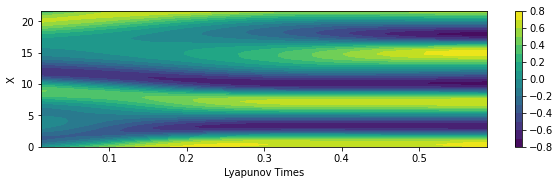

The model solution:


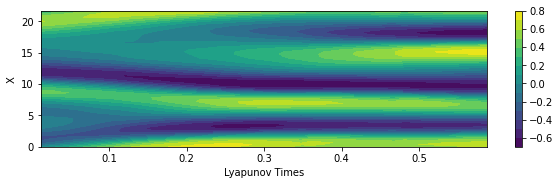

The difference between them:


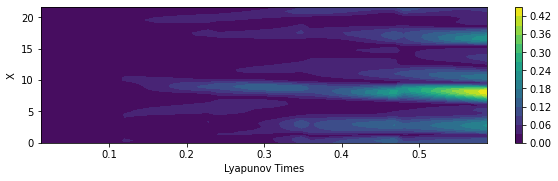

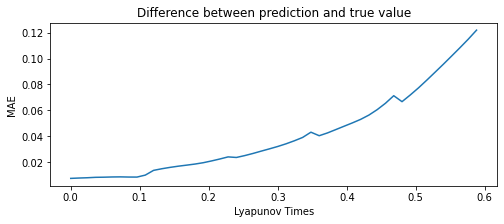

In [40]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()
#state_history_norm_th = state_history_norm_th.unsqueeze(0)
start_position=11000
N_step_simu=5
print('Start_position=', start_position)
pp,yy = prediction(model1_1,start_position,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)

In [ ]:
#conv: 2
#linear: 1

Lin = size_conv_time
in_ch_conv_1 = 64
out_ch_conv_1 = 128
k_conv_1 = 5
st_conv_1 = 2
pad_conv_1 = 2
L_2 = (Lin+2*pad_conv_1-(k_conv_1-1)-1)/st_conv_1+1

k_pool_1= 3
st_pool_1= 1
L_3 = (L_2 - k_pool_1)/st_pool_1 + 1

in_ch_conv_2 = 128
out_ch_conv_2 = 64
k_conv_2 = 4
st_conv_2 = 3
pad_conv_2 = 1
L_4 = (L_3+2*pad_conv_2-(k_conv_2-1)-1)/st_conv_2+1

k_pool_2= 2
st_pool_2= 1
L_5 = (L_4 - k_pool_2)/st_pool_2 + 1

print(L_2)
print(L_3)
print(L_4)
print(L_5)

in_lin = int(sample_points*L_5)
out_lin = int(sample_points*steps_to_predict)

model2_1 = th.nn.Sequential(
    th.nn.Conv1d(in_ch_conv_1,out_ch_conv_1,k_conv_1,st_conv_1,pad_conv_1),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_1,st_pool_1),
    th.nn.Conv1d(in_ch_conv_2,out_ch_conv_2,k_conv_2,st_conv_2,pad_conv_2),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_2,st_pool_2),
    th.nn.Flatten(),
    th.nn.Linear(in_lin,out_lin),
    th.nn.Tanh(),
)
model2_1.double()
model2_1.cuda()
optimizer=th.optim.Adam(model2_1.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()

In [ ]:
epochs_counter=500
batch_size=64
train2(model2_1,X_train_th,Y_train_th,epochs=epochs_counter,batch_size=batch_size)

In [ ]:
#TO SAVE THE MODEL
tosave_data = {'model': model2_1,
               'epoch': epochs_counter,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,}
# Write a pickle file using pytorch
th.save(tosave_data, "modelcv_model2_1_500epochs")

In [ ]:
#conv: 3
#linear: 1

Lin = size_conv_time
in_ch_conv_1 = 64
out_ch_conv_1 = 128
k_conv_1 = 5
st_conv_1 = 1
pad_conv_1 = 2
L_2 = (Lin+2*pad_conv_1-(k_conv_1-1)-1)/st_conv_1+1

k_pool_1= 3
st_pool_1= 1
L_3 = (L_2 - k_pool_1)/st_pool_1 + 1

in_ch_conv_2 = 128
out_ch_conv_2 = 128
k_conv_2 = 4
st_conv_2 = 1
pad_conv_2 = 2
L_4 = (L_3+2*pad_conv_2-(k_conv_2-1)-1)/st_conv_2+1

k_pool_2= 2
st_pool_2= 2
L_5 = (L_4 - k_pool_2)/st_pool_2 + 1

in_ch_conv_3 = 128
out_ch_conv_3 = 64
k_conv_3 = 4
st_conv_3 = 2
pad_conv_3 = 1
L_6 = (L_5+2*pad_conv_3-(k_conv_3-1)-1)/st_conv_3+1

k_pool_3 = 2
st_pool_3 = 1
L_7 = (L_6 - k_pool_3)/st_pool_3 + 1

print(L_2)
print(L_3)
print(L_4)
print(L_5)
print(L_6)
print(L_7)

in_lin = int(sample_points*L_7)
out_lin = int(sample_points*steps_to_predict)

model3_1 = th.nn.Sequential(
    th.nn.Conv1d(in_ch_conv_1,out_ch_conv_1,k_conv_1,st_conv_1,pad_conv_1),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_1,st_pool_1),
    th.nn.Conv1d(in_ch_conv_2,out_ch_conv_2,k_conv_2,st_conv_2,pad_conv_2),
    th.nn.LeakyReLU(),
    th.nn.Conv1d(in_ch_conv_3,out_ch_conv_3,k_conv_3,st_conv_3,pad_conv_3),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_3,st_pool_3),
    th.nn.Flatten(),
    th.nn.Linear(in_lin,out_lin),
    th.nn.Tanh(),
)
model3_1.double()
model3_1.cuda()
optimizer=th.optim.Adam(model3_1.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()

In [ ]:
epochs_counter=500
batch_size=64
train2(model3_1,X_train_th,Y_train_th,epochs=epochs_counter,batch_size=batch_size)

In [ ]:
#TO SAVE THE MODEL
tosave_data = {'model': model3_1,
               'epoch': epochs_counter,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,}
# Write a pickle file using pytorch
th.save(tosave_data, "modelcv_model3_1_500epochs")

In [ ]:
#conv: 1
#linear: 2

Lin = size_conv_time
in_ch_conv_1 = 64
out_ch_conv_1 = 64
k_conv_1 = 5
st_conv_1 = 4
pad_conv_1 = 4
L_2 = (Lin+2*pad_conv_1-(k_conv_1-1)-1)/st_conv_1+1

k_pool_1= 2
st_pool_1= 2
L_3 = (L_2 - k_pool_1)/st_pool_1 + 1

in_lin = int(sample_points*L_3)
out_lin = int(sample_points*steps_to_predict)
hidden_lin = sample_points*7

model1_2 = th.nn.Sequential(
    th.nn.Conv1d(in_ch_conv_1,out_ch_conv_1,k_conv_1,st_conv_1,pad_conv_1),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_1,st_pool_1),
    th.nn.Flatten(),
    th.nn.Linear(in_lin,hidden_lin),
    th.nn.Tanh(),
    th.nn.Linear(hidden_lin,out_lin),
    th.nn.Tanh(),
)
model1_2.double()
model1_2.cuda()
optimizer=th.optim.Adam(model1_2.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()

In [ ]:
epochs_counter=500
batch_size=64
train2(model1_2,X_train_th,Y_train_th,epochs=epochs_counter,batch_size=batch_size)
#TO SAVE THE MODEL
tosave_data = {'model': model1_2,
               'epoch': epochs_counter,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,}
# Write a pickle file using pytorch
th.save(tosave_data, "modelcv_model1_2_500epochs")

In [ ]:
#conv: 2
#linear: 2

Lin = size_conv_time
in_ch_conv_1 = 64
out_ch_conv_1 = 128
k_conv_1 = 5
st_conv_1 = 2
pad_conv_1 = 2
L_2 = (Lin+2*pad_conv_1-(k_conv_1-1)-1)/st_conv_1+1

k_pool_1= 3
st_pool_1= 1
L_3 = (L_2 - k_pool_1)/st_pool_1 + 1

in_ch_conv_2 = 128
out_ch_conv_2 = 64
k_conv_2 = 4
st_conv_2 = 3
pad_conv_2 = 1
L_4 = (L_3+2*pad_conv_2-(k_conv_2-1)-1)/st_conv_2+1

k_pool_2= 2
st_pool_2= 1
L_5 = (L_4 - k_pool_2)/st_pool_2 + 1

print(L_2)
print(L_3)
print(L_4)
print(L_5)

in_lin = int(sample_points*L_5)
out_lin = int(sample_points*steps_to_predict)
hidden_lin = sample_points*7

model2_2 = th.nn.Sequential(
    th.nn.Conv1d(in_ch_conv_1,out_ch_conv_1,k_conv_1,st_conv_1,pad_conv_1),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_1,st_pool_1),
    th.nn.Conv1d(in_ch_conv_2,out_ch_conv_2,k_conv_2,st_conv_2,pad_conv_2),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_2,st_pool_2),
    th.nn.Flatten(),
    th.nn.Linear(in_lin,hidden_lin),
    th.nn.Tanh(),
    th.nn.Linear(hidden_lin,out_lin),
    th.nn.Tanh(),
)
model2_2.double()
model2_2.cuda()
optimizer=th.optim.Adam(model2_2.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()

In [ ]:
epochs_counter=500
batch_size=64
train2(model2_2,X_train_th,Y_train_th,epochs=epochs_counter,batch_size=batch_size)
#TO SAVE THE MODEL
tosave_data = {'model': model2_2,
               'epoch': epochs_counter,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,}
# Write a pickle file using pytorch
th.save(tosave_data, "modelcv_model2_2_500epochs")

In [ ]:
#conv: 3
#linear: 3

Lin = size_conv_time
in_ch_conv_1 = 64
out_ch_conv_1 = 128
k_conv_1 = 5
st_conv_1 = 1
pad_conv_1 = 2
L_2 = (Lin+2*pad_conv_1-(k_conv_1-1)-1)/st_conv_1+1

k_pool_1= 3
st_pool_1= 1
L_3 = (L_2 - k_pool_1)/st_pool_1 + 1

in_ch_conv_2 = 128
out_ch_conv_2 = 128
k_conv_2 = 4
st_conv_2 = 1
pad_conv_2 = 2
L_4 = (L_3+2*pad_conv_2-(k_conv_2-1)-1)/st_conv_2+1

k_pool_2= 2
st_pool_2= 2
L_5 = (L_4 - k_pool_2)/st_pool_2 + 1

in_ch_conv_3 = 128
out_ch_conv_3 = 64
k_conv_3 = 4
st_conv_3 = 2
pad_conv_3 = 1
L_6 = (L_5+2*pad_conv_3-(k_conv_3-1)-1)/st_conv_3+1

k_pool_3 = 2
st_pool_3 = 1
L_7 = (L_6 - k_pool_3)/st_pool_3 + 1

print(L_2)
print(L_3)
print(L_4)
print(L_5)
print(L_6)
print(L_7)

in_lin = int(sample_points*L_7)
out_lin = int(sample_points*steps_to_predict)
hidden_lin = sample_points*7

model3_1 = th.nn.Sequential(
    th.nn.Conv1d(in_ch_conv_1,out_ch_conv_1,k_conv_1,st_conv_1,pad_conv_1),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_1,st_pool_1),
    th.nn.Conv1d(in_ch_conv_2,out_ch_conv_2,k_conv_2,st_conv_2,pad_conv_2),
    th.nn.LeakyReLU(),
    th.nn.Conv1d(in_ch_conv_3,out_ch_conv_3,k_conv_3,st_conv_3,pad_conv_3),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_3,st_pool_3),
    th.nn.Flatten(),
    th.nn.Linear(in_lin,hidden_lin),
    th.nn.Tanh(),
    th.nn.Linear(hidden_lin,hidden_lin),
    th.nn.Tanh(),
    th.nn.Linear(hidden_lin,out_lin),
    th.nn.Tanh(),
)
model3_3.double()
model3_3.cuda()
optimizer=th.optim.Adam(model3_3.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()

In [ ]:
epochs_counter=500
batch_size=64
train2(model2_2,X_train_th,Y_train_th,epochs=epochs_counter,batch_size=batch_size)
#TO SAVE THE MODEL
tosave_data = {'model': model2_2,
               'epoch': epochs_counter,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,}
# Write a pickle file using pytorch
th.save(tosave_data, "modelcv_model2_2_500epochs")